In [1]:
# Importing important packages
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

2026-02-11 14:47:31.901511: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-11 14:47:31.979917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-11 14:47:33.100162: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Import Signal and label Data

In [2]:
# load signal data
Path = "/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/"
signal_files = ["/X_TRAIN.pkl","/X_TEST.pkl","/X_VAL.pkl",]

x_train = list()
x_test = list()
x_val = list()

for i in signal_files:
    if i == "/X_TRAIN.pkl":
        with open(Path + "/X_TRAIN.pkl", "rb") as f:
            x_train = pickle.load(f)
    elif i == "/X_TEST.pkl":
        with open(Path + "/X_TEST.pkl", "rb") as f:
            x_test = pickle.load(f)
    elif i == "/X_VAL.pkl":
        with open(Path + "/X_VAL.pkl", "rb") as f:
            x_val = pickle.load(f)

# convert to from np arrays to tensors
x_train = tf.convert_to_tensor(x_train, dtype = tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype = tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype = tf.float32)

In [3]:
# Verify shapes
print(f"The shapes are:\n- x_train is {x_train.shape} \n- x_test is {x_test.shape} \n- x_val is {x_val.shape}")

The shapes are:
- x_train is (12123, 1000, 12) 
- x_test is (1512, 1000, 12) 
- x_val is (1479, 1000, 12)


In [4]:
# load label data
Path = "/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/"
label_files = ["/Y_TRAIN.pkl","/Y_TEST.pkl","/Y_VAL.pkl",]

for i in label_files:
    if i == "/Y_TRAIN.pkl":
        with open(Path + "/Y_TRAIN.pkl", "rb") as f:
            y_train = pickle.load(f)
    elif i == "/Y_TEST.pkl":
        with open(Path + "/Y_TEST.pkl", "rb") as f:
            y_test = pickle.load(f)
    elif i == "/Y_VAL.pkl":
        with open(Path + "/Y_VAL.pkl", "rb") as f:
            y_val = pickle.load(f)

# process labels
def multihot_encode(pd_series_labels):
    # pandas series to list
    list_labels = pd_series_labels.to_list()

    # convert to ragged vector
    ragged_list_labels = tf.ragged.constant(list_labels)

    # setup string lookup and adapt
    str_lookup_layer = layers.StringLookup(output_mode = "multi_hot")
    str_lookup_layer.adapt(ragged_list_labels) 
    multi_hot_labels = str_lookup_layer(ragged_list_labels)

    return multi_hot_labels

# appyl multi hot encoding
y_train = tf.cast(multihot_encode(y_train),dtype = tf.float32)
y_test = tf.cast(multihot_encode(y_test),dtype = tf.float32)
y_val = tf.cast(multihot_encode(y_val),dtype = tf.float32)

In [5]:
# Verify shapes
print(f"The shapes are:\n- y_train is {y_train.shape} \n- y_test is {y_test.shape} \n- y_val is {y_val.shape}")

The shapes are:
- y_train is (12123, 7) 
- y_test is (1512, 7) 
- y_val is (1479, 7)


## Model Creation

In [6]:
# Conv1D+BiLSTM Model

# Input layers
InputLayer = layers.Input(shape=(1000, 12))

# 1D-CNN Block 1
x = layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, activation = "relu", padding = "same")(InputLayer)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(pool_size = 2)(x) 
x = layers.Dropout(0.3)(x) 

# 1D-CNN Block 2
x = layers.Conv1D(filters = 32, kernel_size = 3, strides = 1, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(pool_size = 2)(x) 
x = layers.Dropout(0.3)(x) 

# Bi-LSTM Block 1
x = layers.Bidirectional(layers.LSTM(units = 64, return_sequences = True))(x)
x = layers.Dropout(0.4)(x)
x = layers.Bidirectional(layers.LSTM(units = 32, return_sequences = False))(x)

# Classification Overhead
x = layers.Dense(units = 128, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(units = 64, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
OutputLayer = layers.Dense(units = 7, activation = "sigmoid")(x)

# Model Creation
model = tf.keras.Model(inputs = InputLayer, outputs = OutputLayer, name = "1DCNN_BiLSTM_Z_Model")

In [7]:
# Define custom metrics

# subclass custom Hamming Loss metric (Not using tensorflow addons here; version clash)
@tf.keras.utils.register_keras_serializable()
class HammingLoss(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return self.total_mismatches / self.total_labels # Hamming Loss formula
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

# subclass custom Hamming score metric
@tf.keras.utils.register_keras_serializable()
class HammingScore(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_score", **kwargs):
        super(HammingScore, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return 1 - (self.total_mismatches / self.total_labels) # Hamming Score = 1 - Hamming loss
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

In [8]:
# model compilation (loss function and optimiser)
roc_auc = tf.keras.metrics.AUC(curve = "ROC", name = "ROC-AUC")
accuracy = tf.keras.metrics.BinaryAccuracy(name = "Accuracy")
recall = tf.keras.metrics.Recall(name = "Recall", thresholds = 0.35)
precision = tf.keras.metrics.Precision(name = "Precision", thresholds = 0.4)
F2_score = tf.keras.metrics.FBetaScore(name = "F2", beta = 2.0, average = "weighted", threshold = 0.35)

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss = tf.keras.losses.binary_focal_crossentropy,
              metrics = [accuracy,
                         roc_auc,
                         F2_score,
                         recall,
                         HammingLoss(), HammingScore()])

In [9]:
# get summary
model.summary()

Model: "1DCNN_BiLSTM_Z_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 64)       │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 250, 128)       │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,375 (462.40 KB)

 Trainable params: 118,183 (461.65 KB)

 Non-trainable params: 192 (768.00 B)

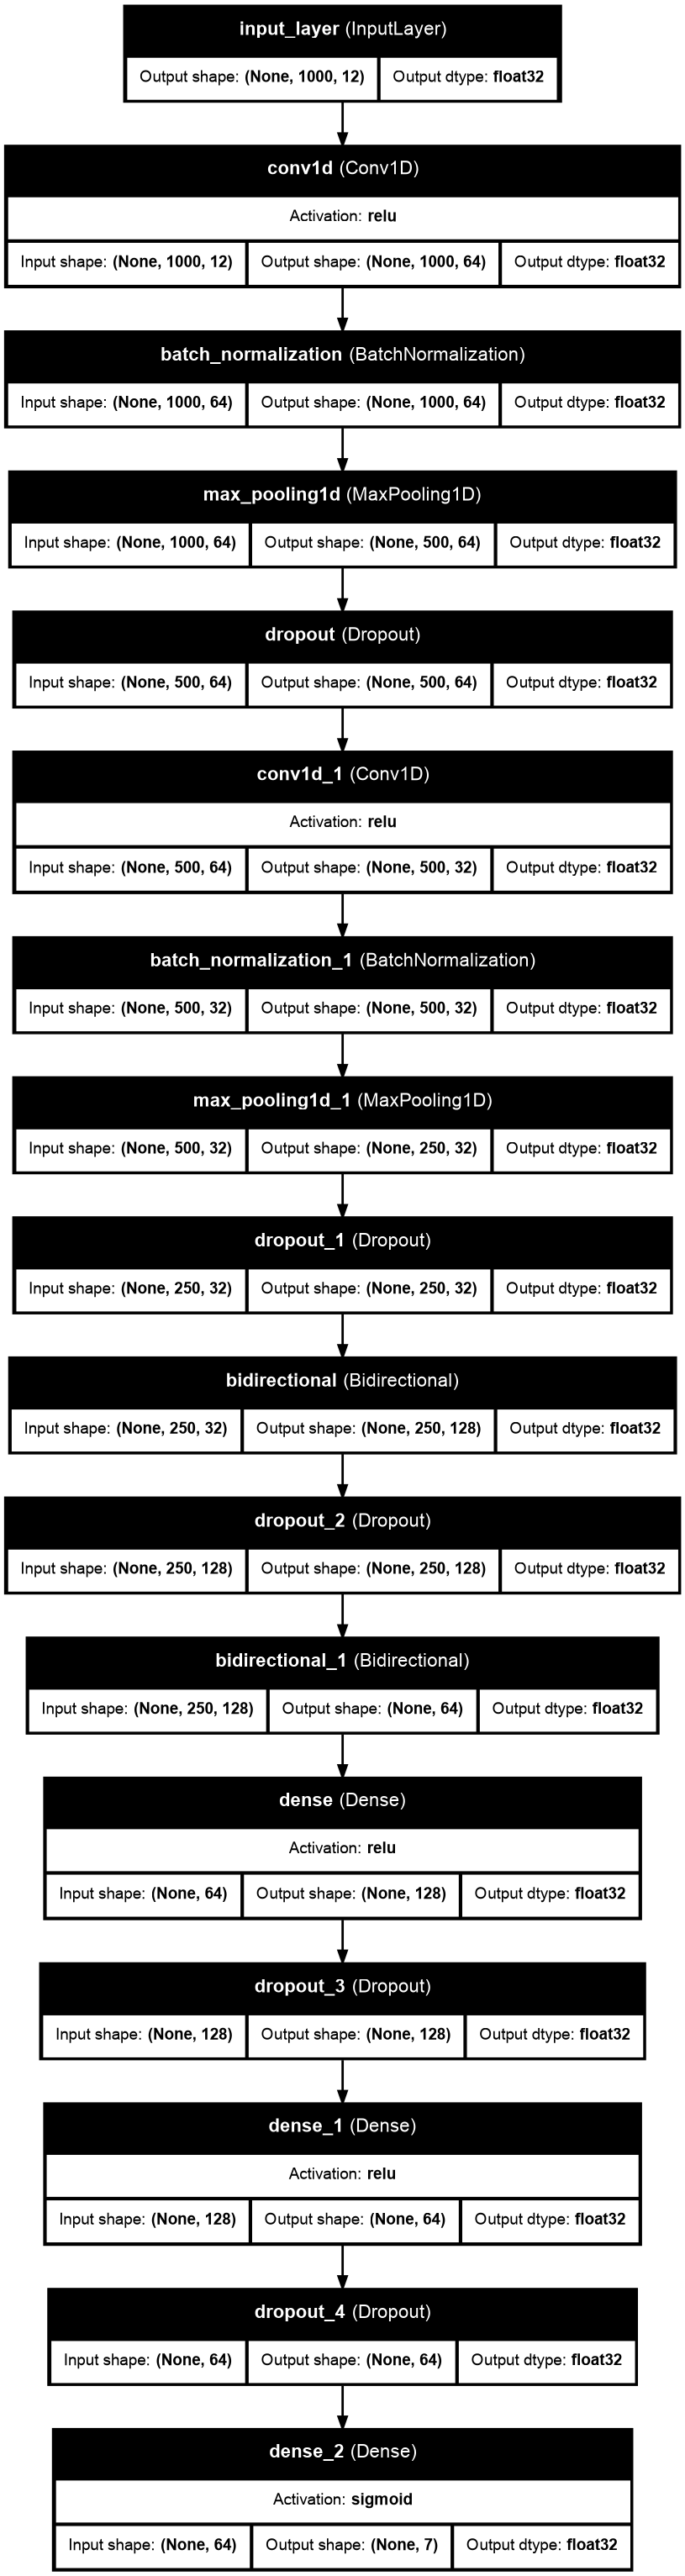

In [10]:
# visualise model
tf.keras.utils.plot_model(model,
                          dpi = 100,
                          to_file = 'Final_Z.png',
                          show_shapes = True,
                          show_dtype = True,
                          show_layer_names = True,
                          show_layer_activations = True)

## Trail Runs

In [11]:
# set callbacks
Callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = "val_Accuracy", patience = 12, restore_best_weights = True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5)
]

In [12]:
# train  model
History = model.fit(
    x = x_train,
    y = y_train,
    validation_data =(x_val, y_val),
    epochs = 100,
    batch_size = 32,
    callbacks = Callbacks
)

Epoch 1/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - Accuracy: 0.8099 - F2: 0.6060 - Hamming_loss: 0.1901 - Hamming_score: 0.8099 - ROC-AUC: 0.7415 - Recall: 0.8302 - loss: 0.1091 - val_Accuracy: 0.8171 - val_F2: 0.6195 - val_Hamming_loss: 0.1829 - val_Hamming_score: 0.8171 - val_ROC-AUC: 0.7645 - val_Recall: 0.8931 - val_loss: 0.1031 - learning_rate: 0.0010
Epoch 2/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - Accuracy: 0.8135 - F2: 0.6121 - Hamming_loss: 0.1865 - Hamming_score: 0.8135 - ROC-AUC: 0.7609 - Recall: 0.8644 - loss: 0.1047 - val_Accuracy: 0.8166 - val_F2: 0.6218 - val_Hamming_loss: 0.1834 - val_Hamming_score: 0.8166 - val_ROC-AUC: 0.7666 - val_Recall: 0.9036 - val_loss: 0.1021 - learning_rate: 0.0010
Epoch 3/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - Accuracy: 0.8148 - F2: 0.6186 - Hamming_loss: 0.1851 - Hamming_score: 0.8149 - ROC-AUC: 0.7651 - Recall: 0.8831 - loss: 0.1034 - val_Accuracy: 0.8172 - val_F2: 0.6198 - val_Hamming_loss: 0.1828 - val_Hamming_score

In [13]:
# evaluate model
Evaluation_result = model.evaluate(
    x = x_test,
    y = y_test,
    batch_size = 32)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - Accuracy: 0.8167 - F2: 0.6216 - Hamming_loss: 0.1833 - Hamming_score: 0.8167 - ROC-AUC: 0.7602 - Recall: 0.9048 - loss: 0.1025


In [14]:
# sample prediction
results = model.predict(x = x_test[99:100])
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
[[0.03473409 0.48517883 0.39270118 0.3887795  0.39124137 0.28543034
  0.23535904]]
